# 17 Movielens영화 SBR

## 17.1 데이터 전처리

### 17.1.1 Data Load

In [1]:
# 데이터 불러오기
from pathlib import Path
import os
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore') # warning 제거

data_path = Path(os.getenv('HOME')+'/aiffel/yoochoose-data/ml-1m') 
train_path = data_path / 'ratings.dat'

def load_data(data_path: Path, nrows=None):
    data = pd.read_csv(data_path, sep='::', header=None, usecols=[0, 1, 2, 3], dtype={0: np.int32, 1: np.int32, 2: np.int32}, nrows=nrows)
    data.columns = ['UserId', 'ItemId', 'Rating', 'Time']
    return data

data = load_data(train_path, None)
data.sort_values(['UserId', 'Time'], inplace=True)  # data를 id와 시간 순서로 정렬해줍니다.
data

,UserId,ItemId,Rating,Time
31,1,3186,4,978300019
22,1,1270,5,978300055
27,1,1721,4,978300055
37,1,1022,5,978300055
24,1,2340,3,978300103
...,...,...,...,...
1000019,6040,2917,4,997454429
999988,6040,1921,4,997454464
1000172,6040,1784,3,997454464
1000167,6040,161,3,997454486


In [2]:
# utc 시간변환
import datetime as dt
from datetime import time
times = data['Time']
date_list = []
for time in times :
    date_data = dt.datetime.fromtimestamp(time)
    date_list.append(date_data)

data['Time'] = date_list
data


,UserId,ItemId,Rating,Time
31,1,3186,4,2001-01-01 07:00:19
22,1,1270,5,2001-01-01 07:00:55
27,1,1721,4,2001-01-01 07:00:55
37,1,1022,5,2001-01-01 07:00:55
24,1,2340,3,2001-01-01 07:01:43
...,...,...,...,...
1000019,6040,2917,4,2001-08-10 23:40:29
999988,6040,1921,4,2001-08-10 23:41:04
1000172,6040,1784,3,2001-08-10 23:41:04
1000167,6040,161,3,2001-08-10 23:41:26


In [3]:
# 유저 수 , 아이템 수 확인

data['UserId'].nunique(), data['ItemId'].nunique()

(6040, 3706)

### 17.1.2 Sesson Length

In [4]:
session_length = data.groupby('UserId').size()
session_length

UserId
1        53
2       129
3        51
4        21
5       198
       ... 
6036    888
6037    202
6038     20
6039    123
6040    341
Length: 6040, dtype: int64

In [5]:
print('각 세션의 길이 정도 :', session_length.median(), session_length.mean())
print('세션 최소길이 :', session_length.min(), ',', '세션 최대길이 :', session_length.max())
print('99.9% 세션의 길이 :', session_length.quantile(0.999))

각 세션의 길이 정도 : 96.0 165.5975165562914
세션 최소길이 : 20 , 세션 최대길이 : 2314
99.9% 세션의 길이 : 1343.181000000005


In [6]:
# 절대다수 세션의 길이에 비해 최대 세션길이가 너무 긺으로 살펴보기

long_session = session_length[session_length==2314].index[0]
data[data['UserId']==long_session]

,UserId,ItemId,Rating,Time
696969,4169,1268,5,2000-08-04 05:09:52
697168,4169,2617,4,2000-08-04 05:09:52
697185,4169,2628,4,2000-08-04 05:09:52
697219,4169,2653,4,2000-08-04 05:09:52
697275,4169,423,3,2000-08-04 05:09:52
...,...,...,...,...
697882,4169,3754,2,2002-06-16 05:52:27
695702,4169,1413,3,2002-06-16 06:03:51
697358,4169,494,4,2002-06-16 06:16:00
695945,4169,1804,2,2002-06-16 06:16:23


이렇게 짧은 시간 안에 다수의 영화를 관람하는것은 불가능. 제거필요

In [7]:
# 세션길이 기준 하위 99.9%까지의 분포 누적합을 시각화

length_count = session_length.groupby(session_length).size()
length_percent_cumsum = length_count.cumsum() / length_count.sum()
length_percent_cumsum_999 = length_percent_cumsum[length_percent_cumsum < 0.999]

length_percent_cumsum_999

20      0.014238
21      0.029305
22      0.042053
23      0.055464
24      0.068874
          ...   
1271    0.998179
1277    0.998344
1286    0.998510
1302    0.998675
1323    0.998841
Length: 736, dtype: float64

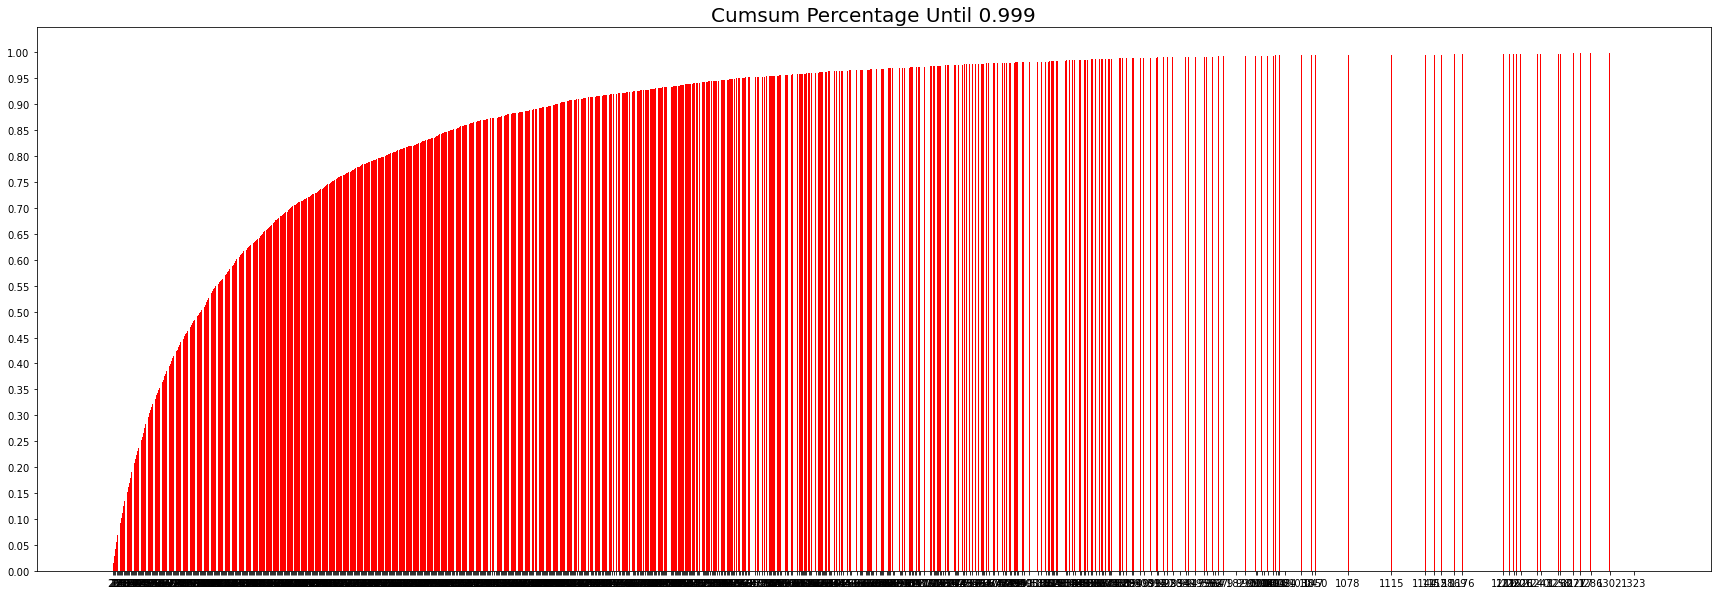

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(30, 10))
plt.bar(x=length_percent_cumsum_999.index,
        height=length_percent_cumsum_999, color='red')
plt.xticks(length_percent_cumsum_999.index)
plt.yticks(np.arange(0, 1.01, 0.05))
plt.title('Cumsum Percentage Until 0.999', size=20)
plt.show()

### 17.1.3 Session Time

In [9]:
# 데이터의 시간 관련 정보 확인

oldest, latest = data['Time'].min(), data['Time'].max()
print(oldest) 
print(latest)

2000-04-26 08:05:32
2003-03-01 02:49:50


In [10]:
type(latest)

pandas._libs.tslibs.timestamps.Timestamp

### 17.1.4 Data Cleansing

In [11]:
# 1인 세션 제거

# short_session을 제거한 다음 unpopular item을 제거하면 다시 길이가 1인 session이 생길 수 있습니다.
# 이를 위해 반복문을 통해 지속적으로 제거 합니다.
def cleanse_recursive(data: pd.DataFrame, shortest, least_click) -> pd.DataFrame:
    while True:
        before_len = len(data)
        data = cleanse_short_session(data, shortest)
        data = cleanse_unpopular_item(data, least_click)
        after_len = len(data)
        if before_len == after_len:
            break
    return data


def cleanse_short_session(data: pd.DataFrame, shortest):
    session_len = data.groupby('UserId').size()
    session_use = session_len[session_len >= shortest].index
    data = data[data['UserId'].isin(session_use)]
    return data


def cleanse_unpopular_item(data: pd.DataFrame, least_click):
    item_popular = data.groupby('ItemId').size()
    item_use = item_popular[item_popular >= least_click].index
    data = data[data['ItemId'].isin(item_use)]
    return data

In [12]:
data = cleanse_recursive(data, shortest=2, least_click=5)
data

,UserId,ItemId,Rating,Time
31,1,3186,4,2001-01-01 07:00:19
22,1,1270,5,2001-01-01 07:00:55
27,1,1721,4,2001-01-01 07:00:55
37,1,1022,5,2001-01-01 07:00:55
24,1,2340,3,2001-01-01 07:01:43
...,...,...,...,...
1000019,6040,2917,4,2001-08-10 23:40:29
999988,6040,1921,4,2001-08-10 23:41:04
1000172,6040,1784,3,2001-08-10 23:41:04
1000167,6040,161,3,2001-08-10 23:41:26


## 17.2 미니배치

### 17.2.1 Train / Valid / Test split

In [13]:
def split_by_date(data: pd.DataFrame, n_days: int):
    final_time = data['Time'].max()
    session_last_time = data.groupby('UserId')['Time'].max()
    session_in_train = session_last_time[session_last_time < final_time - dt.timedelta(n_days)].index
    session_in_test = session_last_time[session_last_time >= final_time - dt.timedelta(n_days)].index

    before_date = data[data['UserId'].isin(session_in_train)]
    after_date = data[data['UserId'].isin(session_in_test)]
    after_date = after_date[after_date['ItemId'].isin(before_date['ItemId'])]
    return before_date, after_date

In [14]:
# test, val set 나누기(약 10%)

tr, test = split_by_date(data, n_days=110)
tr, val = split_by_date(tr, n_days=110)

In [15]:
# data에 대한 정보를 살펴봅니다.
def stats_info(data: pd.DataFrame, status: str):
    print(f'* {status} Set Stats Info\n'
          f'\t Events: {len(data)}\n'
          f'\t Sessions: {data["UserId"].nunique()}\n'
          f'\t Items: {data["ItemId"].nunique()}\n'
          f'\t First Time : {data["Time"].min()}\n'
          f'\t Last Time : {data["Time"].max()}\n')

In [16]:
stats_info(tr, 'train')
stats_info(val, 'valid')
stats_info(test, 'test')

* train Set Stats Info
	 Events: 851286
	 Sessions: 5673
	 Items: 3416
	 First Time : 2000-04-26 08:05:32
	 Last Time : 2002-07-20 06:17:30

* valid Set Stats Info
	 Events: 38108
	 Sessions: 102
	 Items: 2965
	 First Time : 2000-04-28 01:38:08
	 Last Time : 2002-11-08 07:54:07

* test Set Stats Info
	 Events: 110217
	 Sessions: 265
	 Items: 3299
	 First Time : 2000-05-01 20:15:13
	 Last Time : 2003-03-01 02:49:50



In [17]:
# train set에 없는 아이템이 val, test기간에 생길 수 있으므로 train data를 기준으로 인덱싱합니다.
id2idx = {item_id : index for index, item_id in enumerate(tr['ItemId'].unique())}

def indexing(df, id2idx):
    df['item_idx'] = df['ItemId'].map(lambda x: id2idx.get(x, -1))  # id2idx에 없는 아이템은 모르는 값(-1) 처리 해줍니다.
    return df

tr = indexing(tr, id2idx)
val = indexing(val, id2idx)
test = indexing(test, id2idx)

In [18]:
# 데이터 저장

save_path = data_path / 'processed'
save_path.mkdir(parents=True, exist_ok=True)

tr.to_pickle(save_path / 'train.pkl')
val.to_pickle(save_path / 'valid.pkl')
test.to_pickle(save_path / 'test.pkl')

### 17.2.2 SessionDataset

In [19]:
class SessionDataset:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, data):
        self.df = data
        self.click_offsets = self.get_click_offsets()
        self.session_idx = np.arange(self.df['UserId'].nunique())  # indexing to UserId

    def get_click_offsets(self):
        """
        Return the indexes of the first click of each User Ids,
        """
        offsets = np.zeros(self.df['UserId'].nunique() + 1, dtype=np.int32)
        offsets[1:] = self.df.groupby('UserId').size().cumsum()
        return offsets

In [20]:
tr_dataset = SessionDataset(tr)
tr_dataset.df.head(10)

,UserId,ItemId,Rating,Time,item_idx
31,1,3186,4,2001-01-01 07:00:19,0
22,1,1270,5,2001-01-01 07:00:55,1
27,1,1721,4,2001-01-01 07:00:55,2
37,1,1022,5,2001-01-01 07:00:55,3
24,1,2340,3,2001-01-01 07:01:43,4
36,1,1836,5,2001-01-01 07:02:52,5
3,1,3408,4,2001-01-01 07:04:35,6
7,1,2804,5,2001-01-01 07:11:59,7
47,1,1207,4,2001-01-01 07:11:59,8
0,1,1193,5,2001-01-01 07:12:40,9


In [21]:
tr_dataset.click_offsets

array([     0,     53,    182, ..., 850822, 850945, 851286], dtype=int32)

In [22]:
tr_dataset.session_idx

array([   0,    1,    2, ..., 5670, 5671, 5672])

### 17.2.3 SessionDataLoader

In [23]:
# mini-batch생성을 위한 클래스 생성

class SessionDataLoader:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, dataset: SessionDataset, batch_size=50):
        self.dataset = dataset
        self.batch_size = batch_size

    def __iter__(self):
        """ Returns the iterator for producing session-parallel training mini-batches.
        Yields:
            input (B,):  Item indices that will be encoded as one-hot vectors later.
            target (B,): a Variable that stores the target item indices
            masks: Numpy array indicating the positions of the sessions to be terminated
        """

        start, end, mask, last_session, finished = self.initialize()  # initialize 메소드에서 확인해주세요.
        """
        start : Index Where Session Start
        end : Index Where Session End
        mask : indicator for the sessions to be terminated
        """

        while not finished:
            min_len = (end - start).min() - 1  # Shortest Length Among Sessions
            for i in range(min_len):
                # Build inputs & targets
                inp = self.dataset.df['item_idx'].values[start + i]
                target = self.dataset.df['item_idx'].values[start + i + 1]
                yield inp, target, mask

            start, end, mask, last_session, finished = self.update_status(start, end, min_len, last_session, finished)

    def initialize(self):
        first_iters = np.arange(self.batch_size)    # 첫 배치에 사용할 세션 Index를 가져옵니다.
        last_session = self.batch_size - 1    # 마지막으로 다루고 있는 세션 Index를 저장해둡니다.
        start = self.dataset.click_offsets[self.dataset.session_idx[first_iters]]       # data 상에서 session이 시작된 위치를 가져옵니다.
        end = self.dataset.click_offsets[self.dataset.session_idx[first_iters] + 1]  # session이 끝난 위치 바로 다음 위치를 가져옵니다.
        mask = np.array([])   # session의 모든 아이템을 다 돌은 경우 mask에 추가해줄 것입니다.
        finished = False         # data를 전부 돌았는지 기록하기 위한 변수입니다.
        return start, end, mask, last_session, finished

    def update_status(self, start: np.ndarray, end: np.ndarray, min_len: int, last_session: int, finished: bool):  
        # 다음 배치 데이터를 생성하기 위해 상태를 update합니다.
        
        start += min_len   # __iter__에서 min_len 만큼 for문을 돌았으므로 start를 min_len 만큼 더해줍니다.
        mask = np.arange(self.batch_size)[(end - start) == 1]  
        # end는 다음 세션이 시작되는 위치인데 start와 한 칸 차이난다는 것은 session이 끝났다는 뜻입니다. mask에 기록해줍니다.

        for i, idx in enumerate(mask, start=1):  # mask에 추가된 세션 개수만큼 새로운 세션을 돌것입니다.
            new_session = last_session + i  
            if new_session > self.dataset.session_idx[-1]:  # 만약 새로운 세션이 마지막 세션 index보다 크다면 모든 학습데이터를 돈 것입니다.
                finished = True
                break
            # update the next starting/ending point
            start[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session]]     # 종료된 세션 대신 새로운 세션의 시작점을 기록합니다.
            end[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session] + 1]

        last_session += len(mask)  # 마지막 세션의 위치를 기록해둡니다.
        return start, end, mask, last_session, finished

In [24]:
tr_data_loader = SessionDataLoader(tr_dataset, batch_size=4)
tr_dataset.df.head(15)

,UserId,ItemId,Rating,Time,item_idx
31,1,3186,4,2001-01-01 07:00:19,0
22,1,1270,5,2001-01-01 07:00:55,1
27,1,1721,4,2001-01-01 07:00:55,2
37,1,1022,5,2001-01-01 07:00:55,3
24,1,2340,3,2001-01-01 07:01:43,4
36,1,1836,5,2001-01-01 07:02:52,5
3,1,3408,4,2001-01-01 07:04:35,6
7,1,2804,5,2001-01-01 07:11:59,7
47,1,1207,4,2001-01-01 07:11:59,8
0,1,1193,5,2001-01-01 07:12:40,9


In [25]:
iter_ex = iter(tr_data_loader)

In [26]:
inputs, labels, mask =  next(iter_ex)
print(f'Model Input Item Idx are : {inputs}')
print(f'Label Item Idx are : {"":5} {labels}')
print(f'Previous Masked Input Idx are {mask}')

Model Input Item Idx are : [ 0 53 65 54]
Label Item Idx are :       [ 1 54 62 24]
Previous Masked Input Idx are []


## 17.3 모델 구성

In [27]:
# 평가지표 함수 구현

def mrr_k(pred, truth: int, k: int):
    indexing = np.where(pred[:k] == truth)[0]
    if len(indexing) > 0:
        return 1 / (indexing[0] + 1)
    else:
        return 0


def recall_k(pred, truth: int, k: int) -> int:
    answer = truth in pred[:k]
    return int(answer)

### 17.3.1 Model Architecture

In [28]:
# 필요모듈 import

import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, GRU
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm

In [29]:
# 함수 생성

def create_model(args):
    inputs = Input(batch_shape=(args.batch_size, 1, args.num_items))
    gru, _ = GRU(args.hsz, stateful=True, return_state=True, name='GRU')(inputs)
    dropout = Dropout(args.drop_rate)(gru)
    predictions = Dense(args.num_items, activation='softmax')(dropout)
    model = Model(inputs=inputs, outputs=[predictions])
    model.compile(loss=categorical_crossentropy, optimizer=Adam(args.lr), metrics=['accuracy'])
    model.summary()
    return model

In [30]:
# hiper-parameter관리를 위한 class 생성

class Args:
    def __init__(self, tr, val, test, batch_size, hsz, drop_rate, lr, epochs, k):
        self.tr = tr
        self.val = val
        self.test = test
        self.num_items = tr['ItemId'].nunique()
        self.num_sessions = tr['UserId'].nunique()
        self.batch_size = batch_size
        self.hsz = hsz
        self.drop_rate = drop_rate
        self.lr = lr
        self.epochs = epochs
        self.k = k

args = Args(tr, val, test, batch_size=32, hsz=100, drop_rate=0.2, lr=0.001, epochs=5, k=20)

In [31]:
# 모델 생성

model = create_model(args)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(32, 1, 3416)]           0         
_________________________________________________________________
GRU (GRU)                    [(32, 100), (32, 100)]    1055400   
_________________________________________________________________
dropout (Dropout)            (32, 100)                 0         
_________________________________________________________________
dense (Dense)                (32, 3416)                345016    
Total params: 1,400,416
Trainable params: 1,400,416
Non-trainable params: 0
_________________________________________________________________


## 17.4 모델 학습

In [32]:
# 학습 구현
# train 셋으로 학습하면서 valid 셋으로 검증합니다.
def train_model(model, args):
    train_dataset = SessionDataset(args.tr)
    train_loader = SessionDataLoader(train_dataset, batch_size=args.batch_size)

    for epoch in range(1, args.epochs + 1):
        total_step = len(args.tr) - args.tr['UserId'].nunique()
        tr_loader = tqdm(train_loader, total=total_step // args.batch_size, desc='Train', mininterval=1)
        for feat, target, mask in tr_loader:
            reset_hidden_states(model, mask)  # 종료된 session은 hidden_state를 초기화합니다. 아래 메서드에서 확인해주세요.

            input_ohe = to_categorical(feat, num_classes=args.num_items)
            input_ohe = np.expand_dims(input_ohe, axis=1)
            target_ohe = to_categorical(target, num_classes=args.num_items)

            result = model.train_on_batch(input_ohe, target_ohe)
            tr_loader.set_postfix(train_loss=result[0], accuracy = result[1])

        val_recall, val_mrr = get_metrics(args.val, model, args, args.k)  # valid set에 대해 검증합니다.

        print(f"\t - Recall@{args.k} epoch {epoch}: {val_recall:3f}")
        print(f"\t - MRR@{args.k}    epoch {epoch}: {val_mrr:3f}\n")


def reset_hidden_states(model, mask):
    gru_layer = model.get_layer(name='GRU')  # model에서 gru layer를 가져옵니다.
    hidden_states = gru_layer.states[0].numpy()  # gru_layer의 parameter를 가져옵니다.
    for elt in mask:  # mask된 인덱스 즉, 종료된 세션의 인덱스를 돌면서
        hidden_states[elt, :] = 0  # parameter를 초기화 합니다.
    gru_layer.reset_states(states=hidden_states)


def get_metrics(data, model, args, k: int):  # valid셋과 test셋을 평가하는 코드입니다. 
                                             # train과 거의 같지만 mrr, recall을 구하는 라인이 있습니다.
    dataset = SessionDataset(data)
    loader = SessionDataLoader(dataset, batch_size=args.batch_size)
    recall_list, mrr_list = [], []

    total_step = len(data) - data['UserId'].nunique()
    for inputs, label, mask in tqdm(loader, total=total_step // args.batch_size, desc='Evaluation', mininterval=1):
        reset_hidden_states(model, mask)
        input_ohe = to_categorical(inputs, num_classes=args.num_items)
        input_ohe = np.expand_dims(input_ohe, axis=1)

        pred = model.predict(input_ohe, batch_size=args.batch_size)
        pred_arg = tf.argsort(pred, direction='DESCENDING')  # softmax 값이 큰 순서대로 sorting 합니다.

        length = len(inputs)
        recall_list.extend([recall_k(pred_arg[i], label[i], k) for i in range(length)])
        mrr_list.extend([mrr_k(pred_arg[i], label[i], k) for i in range(length)])

    recall, mrr = np.mean(recall_list), np.mean(mrr_list)
    return recall, mrr

In [33]:
# 모델 학습

train_model(model, args)

Train:   0%|          | 0/26425 [00:00<?, ?it/s, accuracy=0, train_loss=5.81]     

	 - Recall@20 epoch 1: 0.260484
	 - MRR@20    epoch 1: 0.074521



Train:   0%|          | 0/26425 [00:00<?, ?it/s, accuracy=0, train_loss=5.8]      

	 - Recall@20 epoch 2: 0.285537
	 - MRR@20    epoch 2: 0.084311



Train:   0%|          | 0/26425 [00:00<?, ?it/s, accuracy=0, train_loss=5.6]      

	 - Recall@20 epoch 3: 0.288786
	 - MRR@20    epoch 3: 0.086468



Train:   0%|          | 0/26425 [00:00<?, ?it/s, accuracy=0, train_loss=5.57]     

	 - Recall@20 epoch 4: 0.291868
	 - MRR@20    epoch 4: 0.087717



Evaluation:  79%|███████▊  | 933/1187 [02:00<00:32,  7.76it/s]

	 - Recall@20 epoch 5: 0.291231
	 - MRR@20    epoch 5: 0.088726



## 17.5 모델 테스트

In [34]:
def test_model(model, args, test):
    test_recall, test_mrr = get_metrics(test, model, args, 20)
    print(f"\t - Recall@{args.k}: {test_recall:3f}")
    print(f"\t - MRR@{args.k}: {test_mrr:3f}\n")

test_model(model, args, test)

Evaluation:  92%|█████████▏| 3154/3436 [06:54<00:37,  7.61it/s]

	 - Recall@20: 0.260176
	 - MRR@20: 0.076965



1. batch_size=64, hsz=50, drop_rate=0.1, lr=0.001, epochs=3, k=20  
  ---> Recall@20: 0.257884, MRR@20: 0.073198   

2. batch_size=32, hsz=50, drop_rate=0.1, lr=0.001, epochs=5, k=20)  
  ---> Recall@20: 0.256936, MRR@20: 0.075179  
    
3. batch_size=32, hsz=30, drop_rate=0.1, lr=0.001, epochs=5, k=20  
  ---> Recall@20: 0.249505,  MRR@20: 0.070761
    
4. batch_size=32, hsz=100, drop_rate=0.2, lr=0.001, epochs=5, k=20  
  ---> Recall@20: 0.260176, MRR@20: 0.076965

# 회고  
첫번째로 utc를 date로 변환하는데 많은 시간이 걸렸다. 진행도중 bach size로 인한 index에러발생. 데이터 범위 수정, val구현 함수코드 살펴보기 등 하이퍼파라미터 생각을 못해서 삽질을 했다.   
프로젝트를 시행하며 제시되는 모든 코드를 이해하지는 못한다. 한줄 한줄 읽어보아야 한다 의식은 하지만 반복적인 복사, 붙여넣기 작업을 하다보면 그냥 흘려보내기 일쑤다. 때때로 발생하는 이런 예기치못한 에러는 비워져가는 머리를 깨워주고 의미있는 삽질을 하게해준다.  
의도적인 삽질 환영합니다.